In [1]:
import os
import numpy as np
import pandas as pd
import json
from copy import deepcopy
import re
# -*- coding:utf-8 -*-

# yesno训练集

In [2]:
anno_path = "../5.Orgnize/文献标注—校对"
anno_l = [ele for ele in os.listdir(anno_path) if 'add' in ele]
txt_path = "../4.Label_prepare/paper_ld_old/"

train_set = {
    "data": [{
        'paragraphs': [],
        'title': "LungB"
    }],
    "version": "LungB"
}
train_qa = []

In [6]:
for anno in anno_l:

    # 读取标注信息
    print(anno)
    df = pd.read_excel("%s/%s" % (anno_path, anno), header=0)
    df.loc[df["是否是致病菌"] == "是", "是否是致病菌"] = "yes"
    df.loc[df["是否是致病菌"] == "不是", "是否是致病菌"] = "no"
    df.loc[df["是否是致病菌"] == "无法确定", "是否是致病菌"] = "not sure"

    # 读取标题和摘要
    df["Title"] = 0  # 添加文献的信息用于后续的识别
    df["Ab"] = 0
    df["Full"] = 0

    for idx in df.index.tolist():

        txt = open("%s/%s/%s.txt" % (txt_path, anno.split("_")[0],
                                     df.loc[idx, "ID"])).readlines()  # 读取标题和摘要
        df.loc[idx, "Title"] = txt[2]
        df.loc[idx, "Ab"] = txt[3]
        df.loc[idx, "Full"] = txt[2] + txt[3]

        # 创建QA样本
        if df.loc[idx, "是否是致病菌"] in ['yes', 'no']:

            # im = (df.loc[idx, "是否是致病菌"] != 'yes')
            qa = {
                'qas': [{
                    'id':
                    '%s:%s' % (df.loc[idx, "ID"], df.loc[idx, "物种名称"]),
                    'question':
                    'Can %s cause Pneumonia?' % df.loc[idx, "物种名称"],
                    'is_impossible':
                    True,
                    'answers':
                    '%s' % df.loc[idx, "是否是致病菌"]
                }],
                'context':
                '%s' % df.loc[idx, "Full"]
            }
            train_qa.append(qa)

#     df.to_csv("input/train/%s.csv" % anno.split("_")[0], header=True, index=False)

train_set['data'][0]["paragraphs"] = train_qa
# json.dump(train_set, open("input/train_set.json", "w"))

Anaerobic_add.xls
Curved_add.xls
GramN_add.xls
GramPc_add.xls
GramPr_add.xls
Intracellular_add.xls


# 验证

In [8]:
import random
from random import choice

random.seed(10)


In [ ]:
re = 2
eval_qa = random.sample(train_qa, int(len(train_qa) / 5))

ttrain_qa = [ele for ele in train_qa if ele not in eval_qa]
ttrain_set = {
    "data": [{
        'paragraphs': ttrain_qa,
        'title': "LungB"
    }],
    "version": "LungB"
}
json.dump(ttrain_set, open("eval/input_%s/ttrain_set.json" % re, "w"))

eval_q = []
eval_a = {}
for i in eval_qa:
    qq = {
        'qas': [{
            'id': i['qas'][0]['id'],
            'question': i['qas'][0]['question']
        }],
        'context': i['context']
    }
    eval_q.append(qq)
    eval_a[i['qas'][0]['id']] = i['qas'][0]['answers']

eval_qset = {
    "data": [{
        'paragraphs': eval_q,
        'title': "LungB"
    }],
    "version": "LungB"
}
json.dump(eval_qset, open("eval/input_%s/eval_qset.json" % re, "w"))
json.dump(eval_a, open("eval/input_%s/eval_aset.json" % re, "w"))

In [9]:
re = 1
eval_a = json.load(open("eval/input_%s/eval_aset.json" % re, "r"))
standard = pd.DataFrame(eval_a, index=["golden"]).T
prediction = json.load(open("eval/output_%s/predictions_.json" % re, 'r'))
prediction = pd.DataFrame(prediction, index=["prediction", "rate"]).T
prediction["cut"] = 1
for i in prediction.index:
    if prediction.loc[i, "rate"][0] > 0.95:
        prediction.loc[i, "cut"] = "yes"
    else:
        prediction.loc[i, "cut"] = "no"

In [10]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

accuracy = accuracy_score(standard["golden"],
                          prediction["cut"],
                          normalize=True,
                          sample_weight=None)
precision = precision_score(standard["golden"],
                            prediction["cut"],
                            labels=None,
                            pos_label='yes',
                            average='binary',
                            sample_weight=None,
                            zero_division='warn')
recall = recall_score(standard["golden"],
                      prediction["cut"],
                      labels=None,
                      pos_label='yes',
                      average='binary',
                      sample_weight=None,
                      zero_division='warn')
f1 = f1_score(standard["golden"],
              prediction["cut"],
              labels=None,
              pos_label='yes',
              average='binary',
              sample_weight=None,
              zero_division='warn')
print(accuracy, precision, recall, f1)

0.8716216216216216 0.7083333333333334 0.8717948717948718 0.7816091954022988


In [17]:
standard["golden"][standard["golden"] == "yes"] = "T"
standard["golden"][standard["golden"] == "no"] = "yes"
standard["golden"][standard["golden"] == "T"] = "no"
prediction["cut"][prediction["cut"] == "yes"] = "T"
prediction["cut"][prediction["cut"] == "no"] = "yes"
prediction["cut"][prediction["cut"] == "T"] = "no"

accuracy = accuracy_score(standard["golden"],
                          prediction["cut"],
                          normalize=True,
                          sample_weight=None)
precision = precision_score(standard["golden"],
                            prediction["cut"],
                            labels=None,
                            pos_label='yes',
                            average='binary',
                            sample_weight=None,
                            zero_division='warn')
recall = recall_score(standard["golden"],
                      prediction["cut"],
                      labels=None,
                      pos_label='yes',
                      average='binary',
                      sample_weight=None,
                      zero_division='warn')
f1 = f1_score(standard["golden"],
              prediction["cut"],
              labels=None,
              pos_label='yes',
              average='binary',
              sample_weight=None,
              zero_division='warn')
print(accuracy, precision, recall, f1)

0.8716216216216216 0.95 0.8715596330275229 0.9090909090909091


# plot roc

In [258]:
standard.loc[standard["golden"] == "yes", "golden"] = 1
standard.loc[standard["golden"] == "no", "golden"] = 0
standard["minus"] = 1 - standard["golden"]
standard_v = np.array(standard.values, dtype="float")

prediction["minus"] = 1
for i in prediction.index:
    prediction.loc[i, "rate"] = prediction.loc[i, "rate"]
    prediction.loc[i, "minus"] = 1 - prediction.loc[i, "rate"]
prediction_v = np.array(prediction.iloc[:, 1:3].values, dtype="float")

# Binarize the output
y_test = standard_v
y_score = prediction_v
n_classes = y_score.shape[1]

In [246]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

Automatically created module for IPython interactive environment


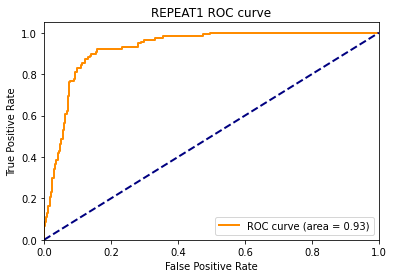

In [247]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
fig  = plt.figure()

plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('REPEAT%s ROC curve' % re)
plt.legend(loc="lower right")
plt.show()
fig.savefig("eval/output_%s/roc_curve.png" % re)

# 预测

In [388]:
sped_path = "../4.Label_prepare/paper_md"
sped_l = [ele for ele in os.listdir(sped_path) if '.' not in ele]

test_set = {"data":[{'paragraphs':[], 'title':"LungB"}], "version":"LungB"}
test_qa = []

for sped in sped_l:
    
    print(sped)
    df = pd.DataFrame(np.zeros((0,4)), columns = ["SPECIES", "Title", "Ab", "Full"])
    
    id_l = [ele for ele in os.listdir("%s/%s" % (sped_path, sped))if 'txt' in ele]
    
    for idx in id_l:
        
        txt = open("%s/%s/%s" % (sped_path, sped, idx)).readlines()
        idx = idx.split(".")[0]
        df.loc[idx] = [txt[0].split(":")[1], txt[2], txt[3], txt[2] + txt[3]]
        
        qa = {'qas': [{
            'id': '%s:%s' % (idx, df.loc[idx, "SPECIES"]),
            'question': 'Can %s cause Pneumonia?' % df.loc[idx, "SPECIES"]}],
            'context': '%s' % df.loc[idx, "Full"]}
        test_qa.append(qa)
    df.to_csv("input/test/%s.csv" % sped, header=True, index=True)

test_set['data'][0]["paragraphs"] = test_qa
json.dump(test_set, open("input/test_set.json", "w"))

Anaerobic
Curved
GramN
GramPc
GramPr
Intracellular


In [11]:
prediction = json.load(open("output/predictions_.json", 'r'))

In [30]:
result = {}
for i in prediction.keys():
    toke = i.split(":")[0]
    species = ""
    for j in toke.split("_")[0:-1]:
        species = species + " " + j
    ncbi = "https://pubmed.ncbi.nlm.nih.gov/%s/" % toke.split("_")[-1]

    result[toke] = [toke.split("_")[-1], species, prediction[i][1][0], ncbi]
    
result = pd.DataFrame(result, index = ["ID", "SPECIES", "rate", "link"]).T

In [31]:
a = result.loc[result["rate"]>0.95, :]
a.to_csv("output/prediction.csv", header=True, index=True)

In [15]:
sped_l = os.listdir("../4.Label_prepare/paper_md/")
for sped in sped_l:
    spec_l = os.listdir("../4.Label_prepare/paper_md/%s" % sped)
    spec_l = [spec.replace(".txt", "") for spec in spec_l]
    spec_tl = [spec for spec in result.index if spec in spec_l]
    spec_yl = [spec for spec in a.index if spec in spec_l]
#     print(sped, len(np.unique(spec_tl)), len(np.unique(spec_yl)))
    specc_tl = [spec.split("_")[0:-1] for spec in spec_tl]
    specc_yl = [spec.split("_")[0:-1] for spec in spec_yl]
    print(sped, len(np.unique(specc_tl)), len(np.unique(specc_yl)))

C:\Users\xinzh\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Anaerobic 27 26
Curved 9 8
GramN 99 94
GramPc 46 42
GramPr 56 53
Intracellular 17 15


In [16]:
b = a["SPECIES"]

c = []
for i in b:
    spec = ""
    for j in i:
        spec = spec + " " + j
        print(spec)
        c.append(spec)
a["SPECIES"] = c.append(spec)

 Actinobacteria
 Actinobacteria
 Actinobacteria
 Actinobacteria
 Actinobacteria
 Actinobacteria
 Actinobacteria
 Actinobacteria
 Actinobacteria
 Actinobacteria
 Actinobacteria
 Actinobacteria
 Actinobacteria
 Actinobacteria
 Actinobacteria
 Actinobacteria
 Actinobacteria
 Actinobacteria
 Actinobacteria
 Actinobacteria
 Actinobacteria
 Actinobacteria
 Actinobacteria
 Actinobacteria
 Actinobacteria
 Actinobacteria
 Actinobacteria
 Actinobacteria
 Actinobacteria
 Actinomyces
 Actinomyces
 Actinomyces
 Actinomyces
 Actinomyces
 Actinomyces
 Actinomyces
 Actinomyces
 Actinomyces
 Actinomyces
 Actinomyces
 Actinomyces
 Actinomyces
 Actinomyces
 Actinomyces
 Actinomyces
 Actinomyces
 Actinomyces
 Actinomyces
 Actinomyces
 Actinomyces
 Actinomyces
 Actinomyces
 Actinomyces
 Actinomyces
 Actinomyces
 Actinomyces
 Actinomyces
 Actinomyces
 Actinomyces
 Actinomyces
 Actinomyces
 Actinomyces
 Actinomyces
 Actinomyces
 Actinomyces
 Actinomyces
 Actinomyces
 Actinomyces
 Actinomyces
 Actinomyces
 Ac

<ipython-input-16-45d15c401fbb>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a["SPECIES"] = c.append(spec)
